# W to Graph Migration Guide

Author: [Serge Rey](http://github.com/sjsrey)

## Introduction

Beginning in the fall of 2023, the PySAL project released a new `graph` module that offers a modern implementation of spatial weights. This module's [Graph](../../generated/libpysal.graph.Graph.html) class is set to eventually replace the [W](../../generated/libpysal.weights.W.html) class, which has been the cornerstone for spatial weights in PySAL for the past 15 years. The `W` class has significantly contributed to the library's success, but as the scientific landscape evolves, new opportunities necessitate updated interfaces and designs for spatial weights.

While the application programming interfaces (API) of the `W` and `Graph` classes are similar, there are important [differences](../../migration.rst)
to consider when transitioning from weights-based resources to graph-based implementations.

This guide is designed to provide users with an overview of migrating from the `W` class to the `Graph` class.

Beyond the specifics that we outline below, it is important to note two utility methods are available to convert between the two classes:

-  `Graph.to_W()` will generate a `W` instance from a `Graph` object
- `Graph.from_W()`will generate a `Graph` instance from a `W` object



## Imports
To access the `W` and `Graph` class, use the following imports:

In [1]:
from libpysal import weights
from libpysal import graph

## Example Data Set

To illustrate the migration from `W` to `Graph` we will utilize a built-in data set from `libpysal`. In addition to the relevant `libpysal` modules we will also import the other packages needed:

In [2]:
%matplotlib inline

import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from libpysal import examples

%load_ext watermark
%watermark -v -d -u -p libpysal

Last updated: 2024-07-18

Python implementation: CPython
Python version       : 3.12.2
IPython version      : 8.21.0

libpysal: 4.2.3.dev1352+gcfa4e0ce



In [3]:
dbs = examples.available()

In [4]:
examples.explain("sids2")

sids2
=====

North Carolina county SIDS death counts and rates
-------------------------------------------------

* sids2.dbf: attribute data. (k=18)
* sids2.html: metadata.
* sids2.shp: Polygon shapefile. (n=100)
* sids2.shx: spatial index.
* sids2.gal: spatial weights in GAL format.

Source: Cressie, Noel (1993). Statistics for Spatial Data. New York, Wiley, pp. 386-389. Rates computed.
Updated URL: https://geodacenter.github.io/data-and-lab/sids2/



In [5]:
# Read the file in
gdf = gpd.read_file(examples.get_path("sids2.shp"))

gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   AREA       100 non-null    float64 
 1   PERIMETER  100 non-null    float64 
 2   CNTY_      100 non-null    int64   
 3   CNTY_ID    100 non-null    int64   
 4   NAME       100 non-null    object  
 5   FIPS       100 non-null    object  
 6   FIPSNO     100 non-null    int64   
 7   CRESS_ID   100 non-null    int64   
 8   BIR74      100 non-null    float64 
 9   SID74      100 non-null    float64 
 10  NWBIR74    100 non-null    float64 
 11  BIR79      100 non-null    float64 
 12  SID79      100 non-null    float64 
 13  NWBIR79    100 non-null    float64 
 14  SIDR74     100 non-null    float64 
 15  SIDR79     100 non-null    float64 
 16  NWR74      100 non-null    float64 
 17  NWR79      100 non-null    float64 
 18  geometry   100 non-null    geometry
dtypes: float64(12), geomet

In [6]:
gdf.geometry

0     POLYGON ((-81.47276 36.23436, -81.54084 36.272...
1     POLYGON ((-81.23989 36.36536, -81.24069 36.379...
2     POLYGON ((-80.45634 36.24256, -80.47639 36.254...
3     MULTIPOLYGON (((-76.00897 36.31960, -76.01735 ...
4     POLYGON ((-77.21767 36.24098, -77.23461 36.214...
                            ...                        
95    POLYGON ((-78.26150 34.39479, -78.32898 34.364...
96    POLYGON ((-78.02592 34.32877, -78.13024 34.364...
97    POLYGON ((-78.65572 33.94867, -79.07450 34.304...
98    POLYGON ((-77.96073 34.18924, -77.96587 34.242...
99    POLYGON ((-78.65572 33.94867, -78.63472 33.977...
Name: geometry, Length: 100, dtype: geometry

In [7]:
gdf = gdf.set_crs("epsg:4326")

In [8]:
gdf.explore()

## Building Spatial Weights
With a GeoDataFrame in hand, we can build  spatial weights using the `W` class as:

In [9]:
w_queen = weights.Queen.from_dataframe(gdf)
w_queen

/tmp/ipykernel_616347/4235704840.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_queen = weights.Queen.from_dataframe(gdf)


For the `Graph`, weights are constructed from the dataframe as:

In [10]:
g_queen = graph.Graph.build_contiguity(gdf, rook=False)
g_queen

<Graph of 100 nodes and 490 nonzero edges indexed by
 [0, 1, 2, 3, 4, ...]>

Two things to be aware of here are:

- the methods have different names for the two classes
- the `W` relies on different methods to generate `Rook` or `Queen` contiguity weights, while the `Graph` relies on the `rook` keyword argument to do so.

## Neighbors
From the output in the previous cells, we see different information reported in the two cases.

The neighbors of a spatial unit are those units that satisfy the specific contiguity relationship specified by the user. In our case of `Queen` contiguity, and pair of polygons that share at least one vertex are considered neighbors.

This information is encoded differently in the two classes. For the `W` class, information on the neighbors is stored in the `neighbors` attribute which is a `dict` using the unit's id as the key, while the `list` of neighbor ids is the value:

In [11]:
type(w_queen.neighbors)

dict

In [12]:
w_queen.neighbors[99]

[96, 97, 98]

For the `Graph` class the neighbor information is stored  in the `adjacency` attribute:

In [13]:
g_queen.adjacency

focal  neighbor
0      1           1
       17          1
       18          1
1      0           1
       2           1
                  ..
98     96          1
       99          1
99     96          1
       97          1
       98          1
Name: weight, Length: 490, dtype: int64

In [14]:
type(g_queen.adjacency)

pandas.core.series.Series

This is encoded as a pandas Series, with a multi-index. The first index is for the focal unit, and the second is for the neighboring unit.
So we see here that the observation with the identifier of 99 has three neighbors: 96, 97, 98.
This agrees with what we had for `W` so the question is why the need for the change?

Part of the answer is in facilitating easier access to this information:

In [15]:
g_queen[99]

neighbor
96    1
97    1
98    1
Name: weight, dtype: int64

here we can query the graph with an id to get the neighbor information, along with the weights attached to each neighbor in the form of a pandas series:

In [16]:
type(g_queen[99])

pandas.core.series.Series

While we could also query the `W` object with an id, we get back a `dict`.

In [17]:
w_queen[99]

{96: 1.0, 97: 1.0, 98: 1.0}

As we will see below, the pandas series will offer substantial gains in efficiency and scope over encoding the weights as `dicts`.

At the same time, if the neighbors are needed in the form of a `dict`, the graph has such an attribute:

In [18]:
g_queen.neighbors

{0: (1, 17, 18),
 1: (0, 2, 17),
 2: (1, 9, 17, 22, 24),
 3: (6, 55),
 4: (5, 8, 15, 27),
 5: (4, 7, 27),
 6: (3, 7, 16),
 7: (5, 6, 16, 19, 20),
 8: (4, 14, 15, 23, 30),
 9: (2, 11, 24, 25),
 10: (11, 13, 26, 28),
 11: (9, 10, 24, 25, 26),
 12: (13, 14, 23, 29, 36),
 13: (10, 12, 28, 29),
 14: (8, 12, 23),
 15: (4, 8, 23, 27, 30, 32, 35),
 16: (6, 7, 19),
 17: (0, 1, 2, 18, 22, 33, 38, 40),
 18: (0, 17, 21, 33),
 19: (7, 16, 20),
 20: (7, 19),
 21: (18, 31, 33, 42, 45),
 22: (2, 17, 24, 38, 39),
 23: (8, 12, 14, 15, 30, 36, 53),
 24: (2, 9, 11, 22, 25, 39, 41),
 25: (9, 11, 24, 26, 41, 46),
 26: (10, 11, 25, 28, 46, 47),
 27: (4, 5, 15, 35, 43),
 28: (10, 13, 26, 29, 47),
 29: (12, 13, 28, 36, 47),
 30: (8, 15, 23, 32, 36, 48, 53),
 31: (21, 34, 45),
 32: (15, 30, 35, 48, 50),
 33: (17, 18, 21, 40, 42, 51),
 34: (31, 37, 45, 52),
 35: (15, 27, 32, 43, 50, 56),
 36: (12, 23, 29, 30, 47, 53, 62),
 37: (34, 52, 54),
 38: (17, 22, 39, 40, 49, 51, 64, 67, 68),
 39: (22, 24, 38, 41, 49),
 4

## Weights

The value of a weight specifies the "strength" of the neighbor relationship between to geographical units.
For our contiguity weights, these will be binary valued.

In the `W` case, these values are stored in the `weights` attribute:

In [19]:
w_queen.weights[99]

[1.0, 1.0, 1.0]

For the `Graph`, the values of the weights are stored in the `adjacency` attribute:

In [20]:
g_queen[99]

neighbor
96    1
97    1
98    1
Name: weight, dtype: int64

Again, the underlying types of these attributes need to be kept in mind. `weights` is a `dict` for `W`, and as part of the `ajacency` attribute of the `Graph`, which is of type:


In [21]:
type(g_queen[0])

pandas.core.series.Series

And, the helper `weights` attribute on the `Graph` mimics that on the `W`.

In [22]:
g_queen.weights[99]

(1, 1, 1)

Individual weight values will be identical between the two implementations:

In [23]:
g_queen[99][97] == w_queen[99][97]

True

As well as the neighbor sets for a given unit:

In [24]:
g_queen[99] == w_queen.weights[99]

neighbor
96    True
97    True
98    True
Name: weight, dtype: bool

In [25]:
w_queen.weights[99]

[1.0, 1.0, 1.0]

We are implicitly assuming that the order of the neighbor ids in the `W` matches that of the `Graph`.
Here we see one advantage of the `Graph` in that the information about the neighbor ids comes along for the ride in the adjacency attribute, or any pandas like queries on that attribute.

To be safe, we would have to double check the ordering of the weights in `W`:

In [26]:
w_queen[99]

{96: 1.0, 97: 1.0, 98: 1.0}

So in this case our equality check above happened to be comparing the values for the same $i,j$ observations, but this is not guaranteed to always be the case. Handling the proper alignment of the ids and the weights was a key motivation for developing the `Graph`.

The key take-away here is that the `Graph` combines the information about who are the neighbors *and* the values of the associated weights in the *same* data structure, the `adjacency` attribute, while in `W` there are *two different* `dicts` that handle the neighbor information and the weights information (`neighbor` and `weights`, respectively).

## Cardinalities
The `cardinalities` attribute contains information on the number of neighbors for each unit.

In [27]:
w_queen.cardinalities

{0: 3,
 1: 3,
 2: 5,
 3: 2,
 4: 4,
 5: 3,
 6: 3,
 7: 5,
 8: 5,
 9: 4,
 10: 4,
 11: 5,
 12: 5,
 13: 4,
 14: 3,
 15: 7,
 16: 3,
 17: 8,
 18: 4,
 19: 3,
 20: 2,
 21: 5,
 22: 5,
 23: 7,
 24: 7,
 25: 6,
 26: 6,
 27: 5,
 28: 5,
 29: 5,
 30: 7,
 31: 3,
 32: 5,
 33: 6,
 34: 4,
 35: 6,
 36: 7,
 37: 3,
 38: 9,
 39: 5,
 40: 4,
 41: 7,
 42: 7,
 43: 5,
 44: 2,
 45: 6,
 46: 6,
 47: 8,
 48: 6,
 49: 6,
 50: 7,
 51: 6,
 52: 7,
 53: 7,
 54: 6,
 55: 2,
 56: 6,
 57: 4,
 58: 4,
 59: 3,
 60: 6,
 61: 6,
 62: 7,
 63: 5,
 64: 6,
 65: 4,
 66: 9,
 67: 5,
 68: 5,
 69: 7,
 70: 6,
 71: 5,
 72: 3,
 73: 6,
 74: 4,
 75: 3,
 76: 2,
 77: 5,
 78: 7,
 79: 2,
 80: 3,
 81: 6,
 82: 5,
 83: 4,
 84: 4,
 85: 5,
 86: 4,
 87: 6,
 88: 5,
 89: 2,
 90: 6,
 91: 4,
 92: 4,
 93: 5,
 94: 3,
 95: 5,
 96: 7,
 97: 4,
 98: 2,
 99: 3}

In [28]:
g_queen.cardinalities

focal
0     3
1     3
2     5
3     2
4     4
     ..
95    5
96    7
97    4
98    2
99    3
Name: cardinalities, Length: 100, dtype: int64

Here we see that, although the attribute name is common to both classes, the data types are different. (Note: other cases of common names but different types that we won't cover here are listed [here](../../migration.rst)).


In [29]:
type(w_queen.cardinalities), type(g_queen.cardinalities)

(dict, pandas.core.series.Series)

Summaries of the cardinality distribution can be obtained for the `W` as:

In [30]:
w_queen.histogram

[(2, 8), (3, 15), (4, 17), (5, 23), (6, 19), (7, 14), (8, 2), (9, 2)]

which indicates that 8 units have 2 neighbors, 15 have 3 neighbors and so on.

For the `Graph` we can more easily visualize this distribution with:

<Axes: >

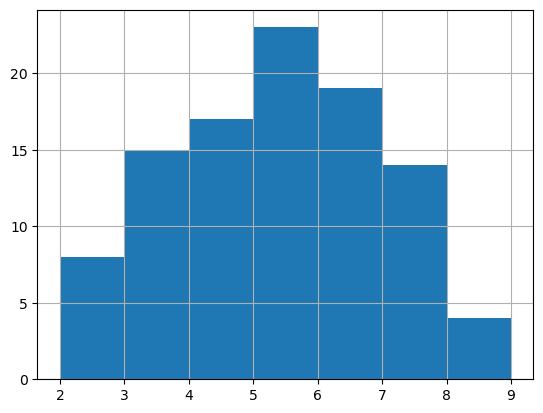

In [31]:
g_queen.cardinalities.hist(bins=range(2, 10))

While to get a similar visualization for `W` requires other packages:

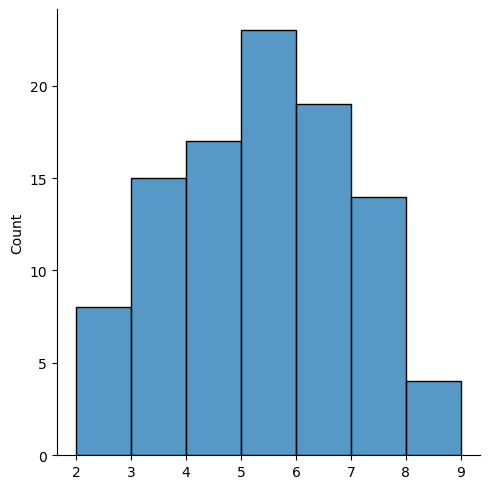

In [32]:
sns.displot(pd.Series(w_queen.cardinalities), bins=range(2, 10));

## Geovisualization of the Weights

Both `W` and `Graph` afford the ability to visualize the connectivity structure as a graph embedded in the geographic space.
For the `W`, the `plot` method can be used

In [33]:
gdf = gdf.to_crs(gdf.estimate_utm_crs())

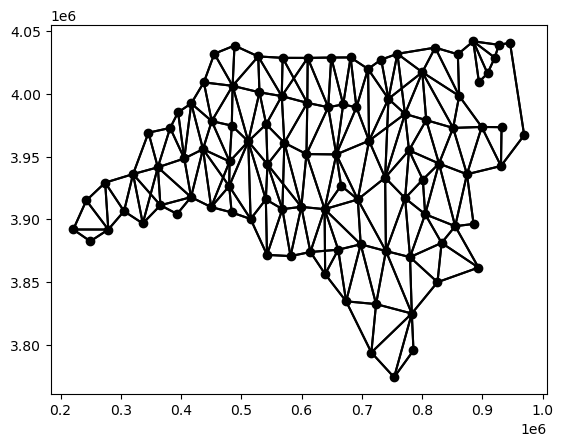

In [34]:
w_queen.plot(gdf);

and the same can be done with the `Graph`:

<Axes: >

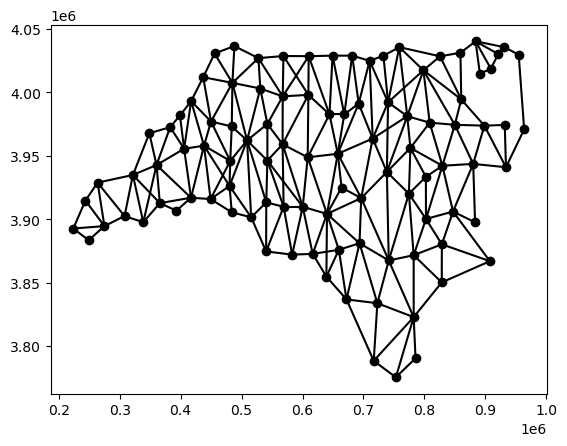

In [35]:
g_queen.plot(gdf)

However, the `Graph` adds an `explore` function allowing for a richer visualization:

In [36]:
m = gdf.explore(tiles="CartoDB Positron")
g_queen.explore(gdf, m=m)

This can be leveraged to look at the spatial distribution of the cardinalities, for example:

In [37]:
g_queen.cardinalities

focal
0     3
1     3
2     5
3     2
4     4
     ..
95    5
96    7
97    4
98    2
99    3
Name: cardinalities, Length: 100, dtype: int64

In [38]:
gdf["cardinalities"] = g_queen.cardinalities

In [39]:
m = gdf.explore(tiles="CartoDB Positron", column="cardinalities", legend=True)
g_queen.explore(gdf, m=m)

## Transformations

Transformation of the weight values is often required in various spatial statistics and operations. How these are handled is a major change between the `W` and `Graph` classes.

PySAL currently supports the following transformations:

- O: original, returning the object to the initial state.
- B: binary, with every neighbor having assigned a weight of one.
- R: row, with all the neighbors of a given observation adding up to one.
- V: variance stabilizing, with the sum of all the weights being constrained to the number of observations.
- D: double, with all the weights across all observations adding up to one.


For the `W`, the `transform` property stores the type of transformation that is associated with the weight values:

In [40]:
w_queen.transform

'O'

An 'O' here means the weight values are set to the original transformation upon construction. In this case they are binary:

In [41]:
w_queen[98]

{96: 1.0, 99: 1.0}

In some cases, rather than using the binary weights, we may need to row-standardize the weights, so that in the full $n \times n$ weights matrix, the row sums would all be equal to unity. The relevant transform in this case is 'r':

In [42]:
w_queen.transform = "r"

In [43]:
w_queen[98]

{96: 0.5, 99: 0.5}

Since `transform` is a property of `W`, setting the `transform` will update the values of the weights.

For the `Graph` class, things have changed in terms of these standardizations.

In [44]:
g_queen[98]

neighbor
96    1
99    1
Name: weight, dtype: int64

In [45]:
g_queen.transform

<bound method Graph.transform of <Graph of 100 nodes and 490 nonzero edges indexed by
 [0, 1, 2, 3, 4, ...]>>

This tells us that the `transform` member is now a method of the `Graph`.

The related change is the addition of a `transformation` property:

In [46]:
g_queen.transformation

'O'

which plays a similar role to the `W.transform` property, in the sense it informs us as to what standardization is associated with the value of the spatial weights.

However, `Graph.transformation` is not a setter in the sense that if the user changes its value, the weight values will not be affected. It is an information-only property.

This is because, by design,   the weights for the `Graph` are **immutable**.
In other words, once the `Graph` instance is created, its state cannot be changed.

If transformed spatial weights are required, the `Graph` method `transform` can be called with the type of transformation required:

In [47]:
g1 = g_queen.transform("r")

In [48]:
g1[98]

neighbor
96    0.5
99    0.5
Name: weight, dtype: float64

This will return a new `Graph` instance with the weight values suitably transformed:


In [49]:
g1.transformation

'R'

## Spatial Lag

The spatial lag of a variable is a weight sum, or weighted average, of the neighboring values for that variable:

$$[Wy]_i = \sum_j w_{i,j} y_j$$

The implementation of the spatial lag has changed between the `W` and `Graph` classes.

To illustrate, we will pull out the Sudden Infant Death Rate in 1979 for the counties into the variable `y`:

In [50]:
y = gdf.SID79

To calculate the spatial lag as a weighted average, we need to use the weights that have been row-standardized. For the `W` class, the calculation of the spatial lag is done with a function that takes the `W` as an argument together with the variable of interest:

In [51]:
from libpysal.weights import lag_spatial

In [52]:
w_queen.transform = 'r'
wlag = lag_spatial(w_queen, y)

In [53]:
wlag

array([ 3.66666667,  4.33333333,  6.8       ,  1.5       ,  7.25      ,
        3.33333333,  2.66666667,  2.4       ,  6.6       , 16.75      ,
        6.5       , 14.8       , 12.6       ,  8.5       ,  2.        ,
        3.85714286,  1.33333333,  3.375     ,  4.        ,  2.33333333,
        1.        ,  6.4       ,  7.8       , 11.42857143,  9.42857143,
        9.83333333, 11.        ,  5.2       ,  8.4       ,  9.6       ,
       12.14285714,  2.        ,  9.8       ,  7.66666667,  6.75      ,
        7.66666667,  8.42857143,  9.        , 11.55555556,  8.        ,
       10.5       , 13.42857143, 10.14285714,  2.        ,  0.        ,
        7.33333333, 12.16666667, 12.875     , 11.16666667,  8.5       ,
        9.        ,  9.83333333,  5.14285714, 12.57142857,  6.5       ,
        1.        ,  5.16666667,  4.25      , 15.25      ,  6.        ,
       11.16666667,  9.16666667, 17.        , 15.4       , 20.5       ,
        4.25      , 13.88888889, 13.4       , 12.8       ,  7.28

For the `Graph`, the `lag` is now a method:

In [54]:
glag = g1.lag(y)

In [55]:
glag

array([ 3.66666667,  4.33333333,  6.8       ,  1.5       ,  7.25      ,
        3.33333333,  2.66666667,  2.4       ,  6.6       , 16.75      ,
        6.5       , 14.8       , 12.6       ,  8.5       ,  2.        ,
        3.85714286,  1.33333333,  3.375     ,  4.        ,  2.33333333,
        1.        ,  6.4       ,  7.8       , 11.42857143,  9.42857143,
        9.83333333, 11.        ,  5.2       ,  8.4       ,  9.6       ,
       12.14285714,  2.        ,  9.8       ,  7.66666667,  6.75      ,
        7.66666667,  8.42857143,  9.        , 11.55555556,  8.        ,
       10.5       , 13.42857143, 10.14285714,  2.        ,  0.        ,
        7.33333333, 12.16666667, 12.875     , 11.16666667,  8.5       ,
        9.        ,  9.83333333,  5.14285714, 12.57142857,  6.5       ,
        1.        ,  5.16666667,  4.25      , 15.25      ,  6.        ,
       11.16666667,  9.16666667, 17.        , 15.4       , 20.5       ,
        4.25      , 13.88888889, 13.4       , 12.8       ,  7.28

## Pandas operations

As mentioned above, gains in efficiency and scope have been the main motivating forces behind the development of the new `Graph` class. Here we highlight a few additional gains.

The `adjacency` attribute for the `Graph` lets users leverage the power of pandas series. For example, the operation:

In [56]:
g_queen[99]

neighbor
96    1
97    1
98    1
Name: weight, dtype: int64

is actually a [slice](https://pandas.pydata.org/docs/user_guide/indexing.html) of the `Graph`  that returns another pandas series where the index is  the id of the neighboring unit and the value is the weight of that neighbor relationship.


In [57]:
g_queen.adjacency.index

MultiIndex([( 0,  1),
            ( 0, 17),
            ( 0, 18),
            ( 1,  0),
            ( 1,  2),
            ( 1, 17),
            ( 2,  1),
            ( 2,  9),
            ( 2, 17),
            ( 2, 22),
            ...
            (96, 99),
            (97, 93),
            (97, 95),
            (97, 96),
            (97, 99),
            (98, 96),
            (98, 99),
            (99, 96),
            (99, 97),
            (99, 98)],
           names=['focal', 'neighbor'], length=490)

In [58]:
g_queen[99].index

Index([96, 97, 98], dtype='int64', name='neighbor')

In [59]:
g_queen.adjacency.loc[[96, 97, 98]]

focal  neighbor
96     78          1
       87          1
       92          1
       95          1
       97          1
       98          1
       99          1
97     93          1
       95          1
       96          1
       99          1
98     96          1
       99          1
Name: weight, dtype: int64

Another way the `Graph` makes use of the powerful indexing afforded by pandas is seen it the method `subgraph`:

In [60]:
g1 = g_queen.subgraph([96, 97, 98])

In [61]:
g1.adjacency

focal  neighbor
96     97          1
       98          1
97     96          1
98     96          1
Name: weight, dtype: int64

In [62]:
g1.n

3

This allows more efficient extraction of subgraphs from the weights graph, relative to the way this is done with the `W` class:

In [63]:
from libpysal.weights import w_subset

In [64]:
w1 = w_subset(w_queen, [96, 97, 98])

In [65]:
w1.weights

{96: [1.0, 1.0], 97: [1.0], 98: [1.0]}

In [66]:
w1.n

3

The index of the dataframe can also be set to a more informative attribute than simple integers:

In [67]:
ngdf = gdf.set_index('NAME')

Once this is done, the new `NAME` based index will propagate to any `Graph` built on this dataframe:

In [68]:
g = graph.Graph.build_contiguity(ngdf, rook=False)

This facilities more user-friendly queries. For example, we can ask who are the neighbors for Ashe county:

In [69]:
g['Ashe']

neighbor
Alleghany    1
Wilkes       1
Watauga      1
Name: weight, dtype: int64

We encountered the `explore` method of the `Graph` above. This can also make handy use of the name-based indexing:

In [70]:
m = ngdf.loc[g['Ashe'].index].explore(color="#25b497")
ngdf.loc[['Ashe']].explore(m=m, color="#fa94a5")
g.explore(ngdf, m=m, focal='Ashe')

## Conclusion

This notebook highlights the main areas that users need to be aware of when considering porting their code from the `W` class to the new `Graph`.
More details on the specifications and differences of the graphs can be found in the [W to Graph Member Comparisions](../../migration.rst).

Downstream packages in the pysal family are in the process of supporting the new `Graph` while preserving backwards compatibility with the `W` class.

## Further Reading

-  Anselin, L. and S.J. Rey (2014) *[Modern Spatial Econometrics in Practice, Chs 3,4](https://www.amazon.com/Modern-Spatial-Econometrics-Practice-GeoDaSpace/dp/0986342106)*. GeoDa Press.
-  Arribas-Bel, D. (2019). *[Geographic Data Science, Lab 4](https://darribas.org/gds_course/content/bE/lab_E.html)*
-  Fleischmann, M. (2024). *[Spatial Data Science for Social Geography, Ch 4](https://martinfleischmann.net/sds/chapter_04/hands_on.html)*
-  Knaap, E. (2024). *[Urban Analysis & Spatial Science, Ch 9](https://knaaptime.com/urban_analysis/03_esda/spatial_graphs.html)*
-  Rey, S.J., D. Arribas-Bel, & L.J. Wolf. (2023) *[Geographic Data Science with Python](https://www.routledge.com/Geographic-Data-Science-with-Python/Rey-Arribas-Bel-Wolf/p/book/9781032445953?gad_source=1&gclid=CjwKCAjw1920BhA3EiwAJT3lScLq-TnzytfU0JRyROH9eOG97U4r7YX3G0ZCs3p5mVGUymqptvNe6hoCkqcQAvD_BwE)*. CRC/Taylor Francis. [Chapter 4](https://geographicdata.science/book/notebooks/04_spatial_weights.html).
